Mylia competition baseline.

In [126]:
import os
import re
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge

import anndata as ad
import scanpy as sc
from scipy import sparse
import sys

In [127]:
SEED = 6
EMBED_DIM = 128        # gene embedding size from control cells
OUT_PCA_K = 64         # number of output PCA components
RIDGE_ALPHA = 1.0      # ridge strength
CTRL_CELL_SAMPLE = 15000  # sample control cells for speed/memory
np.random.seed(SEED)

In [128]:
df_means = pd.read_csv('data/training_data_means.csv')
df_valmap = pd.read_csv("data/pert_ids_val.csv")

In [129]:
gene_columns = [c for c in df_means.columns if c != "pert_symbol"]
baseline_mask = df_means["pert_symbol"] == "non-targeting"
x_base = df_means.iloc[80, 1:].to_numpy(dtype=np.float32)
x_base

array([0.47406167, 0.02579673, 0.09324449, ..., 0.7198073 , 0.7073531 ,
       0.681142  ], shape=(5127,), dtype=float32)

In [130]:
df_train = df_means.loc[~baseline_mask].reset_index(drop=True)
train_genes = df_train["pert_symbol"].astype(str).values
missing_train = sorted({g for g in train_genes if g not in gene_columns})

In [131]:
X_train_means = df_train[gene_columns].to_numpy(dtype=np.float32) # Only gene columns
D_train = X_train_means - x_base[None, :] # Subtract baseline
n_train = D_train.shape[0] # Training perturbations

In [132]:
X_train_means, x_base[None, :]

(array([[0.3116421 , 0.02210249, 0.10094855, ..., 0.64772666, 0.720461  ,
         0.6035719 ],
        [0.627445  , 0.04396126, 0.09433507, ..., 0.8013022 , 0.5453445 ,
         0.55356663],
        [0.4671139 , 0.0307136 , 0.09090973, ..., 0.70924103, 0.6747466 ,
         0.6677914 ],
        ...,
        [0.44308463, 0.04487351, 0.12330244, ..., 0.76513106, 0.63349336,
         0.65966415],
        [0.49848914, 0.00916384, 0.09652278, ..., 0.6987103 , 0.69961   ,
         0.6349703 ],
        [0.48189428, 0.02340364, 0.08553333, ..., 0.6939983 , 0.7037828 ,
         0.72695136]], shape=(80, 5127), dtype=float32),
 array([[0.47406167, 0.02579673, 0.09324449, ..., 0.7198073 , 0.7073531 ,
         0.681142  ]], shape=(1, 5127), dtype=float32))

In [133]:
delta_baseline = D_train.mean(axis=0)
val_map = dict(zip(df_valmap["pert_id"].astype(str), df_valmap["pert"].astype(str)))

In [134]:
adata = ad.read_h5ad("Data/training_cells.h5ad")
adata.obs

,nCount_RNA,nFeature_RNA,percent.mt,sgrna_id,sgrna_symbol,channel
AAACCAAAGACGCGAA_ch_1,16395.0,4191,4.306191,INSIG1_3,INSIG1,ch_1
AAACCAAAGCAAATGA_ch_1,12000.0,3631,3.133333,FLNA_2,FLNA,ch_1
AAACCAAAGCAGTCTA_ch_1,55050.0,7061,5.193460,EIF3H_2,EIF3H,ch_1
AAACCAAAGGGCATAG_ch_1,19586.0,5010,6.494435,DZIP3_4,DZIP3,ch_1
AAACCATTCCAATCGA_ch_1,18744.0,4697,4.604140,non-targeting_25,non-targeting,ch_1
...,...,...,...,...,...,...
GTTGTCCGTCCAGTGA_ch_4,21242.0,4904,4.057998,METTL3_4,METTL3,ch_4
GTTGTCCGTGGGTTTG_ch_4,17462.0,4674,3.928531,non-targeting_25,non-targeting,ch_4
GTTGTCTTCCCCAACC_ch_4,10459.0,3350,6.922268,IKBKG_1,IKBKG,ch_4
GTTGTCTTCCCTTCTC_ch_4,29779.0,5709,3.680446,EGFR_2,EGFR,ch_4


In [135]:
ctrl_mask = adata.obs["sgrna_symbol"] == "non-targeting"
adata_ctrl = adata[ctrl_mask].copy()
print(f"Control cells: {adata_ctrl.n_obs:,}")

Control cells: 1,026


In [136]:
varnames = adata_ctrl.var_names.astype(str)
gene_set = set(gene_columns)
keep_mask = np.array([g in gene_set for g in varnames], dtype=bool)
adata_ctrl = adata_ctrl[:, keep_mask].copy()
adata_ctrl.obs

,nCount_RNA,nFeature_RNA,percent.mt,sgrna_id,sgrna_symbol,channel
AAACCATTCCAATCGA_ch_1,18744.0,4697,4.604140,non-targeting_25,non-targeting,ch_1
AAACCCATCCACAGGT_ch_1,15884.0,4091,4.312516,non-targeting_16,non-targeting,ch_1
AAACGGTAGAGTATTC_ch_1,16384.0,4530,6.927490,non-targeting_3,non-targeting,ch_1
AAAGCTCGTCATTATC_ch_1,11459.0,3549,7.984990,non-targeting_23,non-targeting,ch_1
AAAGTTACAGTACGCC_ch_1,15468.0,4271,5.559866,non-targeting_4,non-targeting,ch_1
...,...,...,...,...,...,...
GTTCATCTCAACCAAT_ch_4,21801.0,5063,5.880464,non-targeting_12,non-targeting,ch_4
GTTCATTGTGGTTGGC_ch_4,16503.0,4525,4.593104,non-targeting_1,non-targeting,ch_4
GTTCTACTCCCTAGGG_ch_4,16918.0,4403,5.177917,non-targeting_12,non-targeting,ch_4
GTTGGAACAAAAGGCC_ch_4,27303.0,5495,6.182471,non-targeting_16,non-targeting,ch_4


In [137]:
gene_to_idx = {}
for i, gene in enumerate(adata_ctrl.var_names.astype(str)):
    gene_to_idx[gene] = i

gene_to_idx

{'A1BG': 0,
 'A1CF': 1,
 'AADAC': 2,
 'AAK1': 3,
 'AARS1': 4,
 'AASS': 5,
 'ABCA1': 6,
 'ABCA12': 7,
 'ABCA5': 8,
 'ABCB5': 9,
 'ABCC1': 10,
 'ABCC2': 11,
 'ABCC3': 12,
 'ABCC4': 13,
 'ABCG2': 14,
 'ABHD12B': 15,
 'ABHD17C': 16,
 'ABHD2': 17,
 'ABHD3': 18,
 'ABHD4': 19,
 'ABI3BP': 20,
 'ABLIM1': 21,
 'ABLIM3': 22,
 'ABRACL': 23,
 'ABTB2': 24,
 'ABTB3': 25,
 'ACAD8': 26,
 'ACADVL': 27,
 'ACAT2': 28,
 'ACER2': 29,
 'ACKR3': 30,
 'ACLY': 31,
 'ACO1': 32,
 'ACOT13': 33,
 'ACOT2': 34,
 'ACOX2': 35,
 'ACP6': 36,
 'ACSBG1': 37,
 'ACSL4': 38,
 'ACSM2A': 39,
 'ACSS3': 40,
 'ACTA2': 41,
 'ACTB': 42,
 'ACTG1': 43,
 'ACTG2': 44,
 'ACTL6A': 45,
 'ACTL8': 46,
 'ACTN1': 47,
 'ACTN4': 48,
 'ACTR2': 49,
 'ACTR3': 50,
 'ACVR1B': 51,
 'ACYP2': 52,
 'ADAM10': 53,
 'ADAM12': 54,
 'ADAM19': 55,
 'ADAM21': 56,
 'ADAM22': 57,
 'ADAM23': 58,
 'ADAM32': 59,
 'ADAM9': 60,
 'ADAMTS10': 61,
 'ADAMTS12': 62,
 'ADAMTS13': 63,
 'ADAMTS16': 64,
 'ADAMTS18': 65,
 'ADAMTS2': 66,
 'ADAMTS20': 67,
 'ADAMTS6': 68,
 'ADAMTS

In [138]:
ordered_idx = [gene_to_idx[g] for g in gene_columns]
adata_ctrl = adata_ctrl[:, ordered_idx].copy()

In [139]:
sc.pp.normalize_total(adata_ctrl, target_sum=1e4, inplace=True)

In [140]:
X = adata_ctrl.X

In [141]:
sparse.issparse(X)

True

In [142]:
X = X.tocsr(copy=True)
X.data = np.log2(X.data + 1.0).astype(np.float32)

In [143]:
svd = TruncatedSVD(n_components=EMBED_DIM, random_state=SEED)
svd.fit(X)  # X: (n_cells, 5127)

,"n_components n_components: int, default=2Desired dimensionality of output data.If algorithm='arpack', must be strictly less than the number of features.If algorithm='randomized', must be less than or equal to the number of features.The default value is useful for visualisation. For LSA, a value of100 is recommended.",128
,"algorithm algorithm: {'arpack', 'randomized'}, default='randomized'SVD solver to use. Either ""arpack"" for the ARPACK wrapper in SciPy(scipy.sparse.linalg.svds), or ""randomized"" for the randomizedalgorithm due to Halko (2009).",'randomized'
,"n_iter n_iter: int, default=5Number of iterations for randomized SVD solver. Not used by ARPACK. Thedefault is larger than the default in:func:`~sklearn.utils.extmath.randomized_svd` to handle sparsematrices that may have large slowly decaying spectrum.",5
,"n_oversamples n_oversamples: int, default=10Number of oversamples for randomized SVD solver. Not used by ARPACK.See :func:`~sklearn.utils.extmath.randomized_svd` for a completedescription... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD solver.Not used by ARPACK. See :func:`~sklearn.utils.extmath.randomized_svd`for more details... versionadded:: 1.1",'auto'
,"random_state random_state: int, RandomState instance or None, default=NoneUsed during randomized svd. Pass an int for reproducible results acrossmultiple function calls.See :term:`Glossary `.",6
,"tol tol: float, default=0.0Tolerance for ARPACK. 0 means machine precision. Ignored by randomizedSVD solver.",0.0


In [144]:
svd.components_.shape   # shape = (k, genes)

(128, 5127)

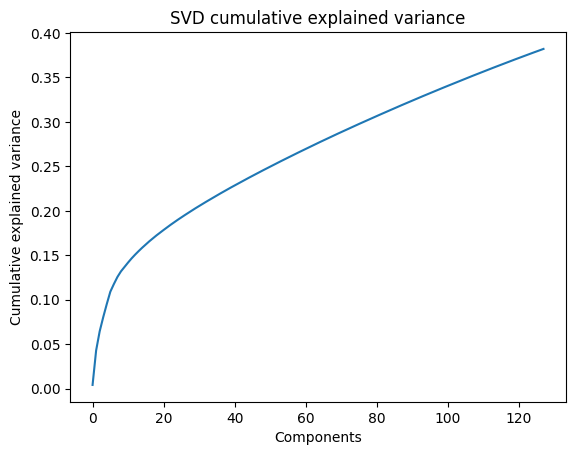

In [145]:
import matplotlib.pyplot as plt
import numpy as np

evr = svd.explained_variance_ratio_

plt.plot(np.cumsum(evr))
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("SVD cumulative explained variance")
plt.show()

High dimensional and messy. Using 128 TruncatedSVD components captures about 37% of the total variance.

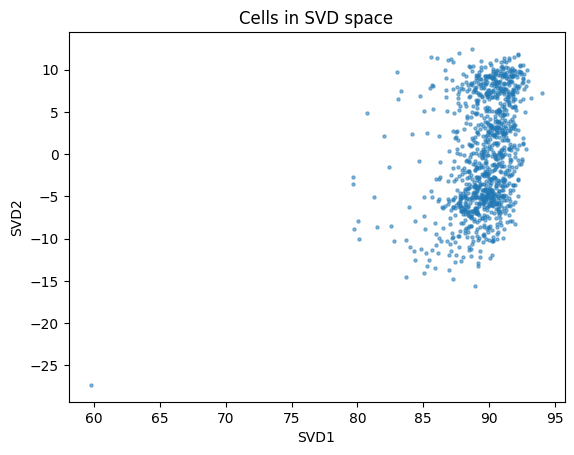

In [146]:
Z = svd.transform(X)
plt.scatter(Z[:,0], Z[:,1], s=5, alpha=0.5)
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.title("Cells in SVD space")
plt.show()

Pretty big outlier in the bottom left corner.

In [147]:
Z = svd.transform(X)
obs = adata_ctrl.obs

import numpy as np
print("corr(SVD1, nCount_RNA):", np.corrcoef(Z[:,0], obs["nCount_RNA"].values)[0,1])
print("corr(SVD1, percent.mt):", np.corrcoef(Z[:,0], obs["percent.mt"].values)[0,1])

corr(SVD1, nCount_RNA): 0.624054295601635
corr(SVD1, percent.mt): -0.2631010184372857


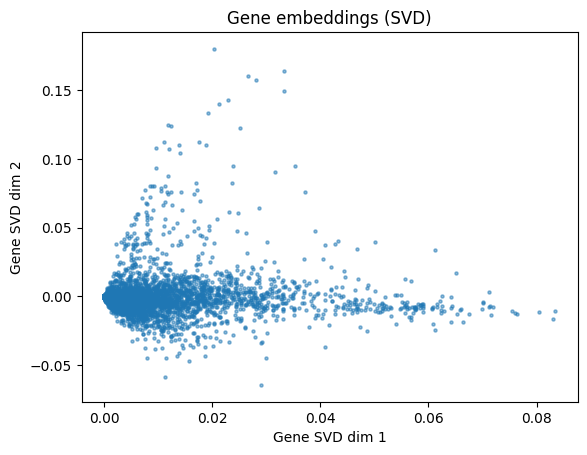

In [148]:
gene_emb = svd.components_.T   # (genes × k)
G = gene_emb

plt.scatter(G[:,0], G[:,1], s=5, alpha=0.5)
plt.xlabel("Gene SVD dim 1")
plt.ylabel("Gene SVD dim 2")
plt.title("Gene embeddings (SVD)")
plt.show()

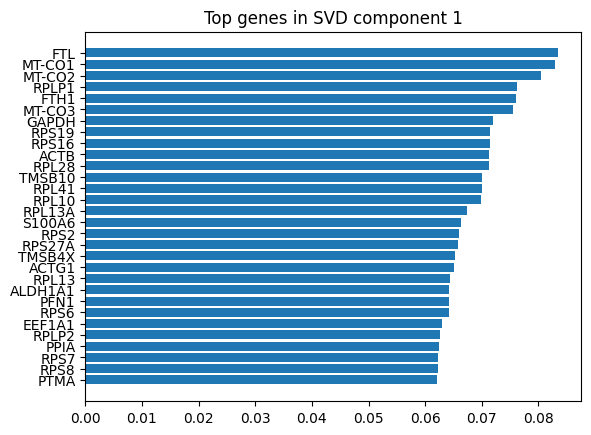

In [149]:
comp = svd.components_[0]   # first component weights
idx = np.argsort(np.abs(comp))[-30:]

plt.barh(range(30), comp[idx])
plt.yticks(range(30), np.array(gene_columns)[idx])
plt.title("Top genes in SVD component 1")
plt.show()


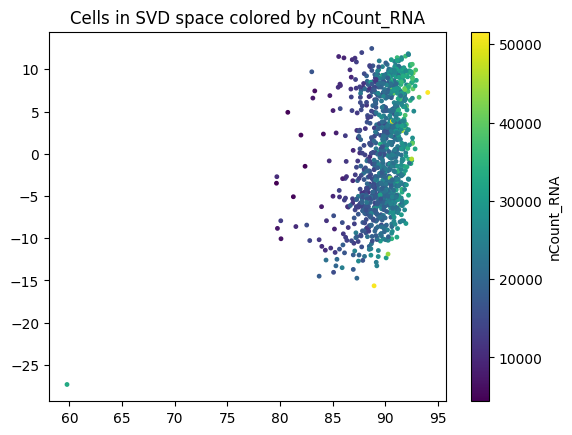

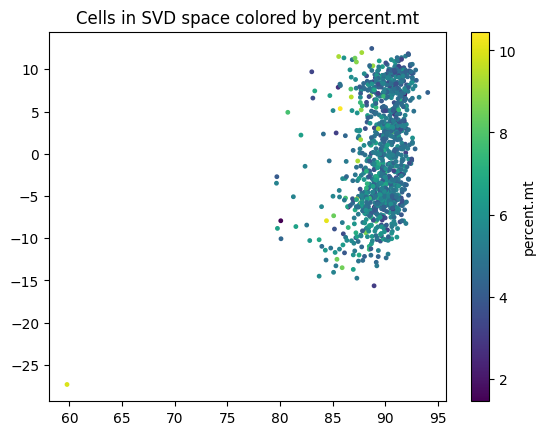

In [150]:
Z = svd.transform(X)

plt.scatter(Z[:,0], Z[:,1], c=adata_ctrl.obs["nCount_RNA"], s=6)
plt.colorbar(label="nCount_RNA")
plt.title("Cells in SVD space colored by nCount_RNA")
plt.show()

plt.scatter(Z[:,0], Z[:,1], c=adata_ctrl.obs["percent.mt"], s=6)
plt.colorbar(label="percent.mt")
plt.title("Cells in SVD space colored by percent.mt")
plt.show()


In [151]:
gene_emb = svd.components_.T.astype(np.float32)
gene2emb = {g: gene_emb[i] for i, g in enumerate(gene_columns)}
emb_fallback = gene_emb.mean(axis=0)

In [152]:
out_pca = PCA(n_components=min(OUT_PCA_K, n_train - 1), random_state=SEED)
C_train = out_pca.fit_transform(D_train)  # (n_train, K)
K = C_train.shape[1]
print(f"Output PCA components used: K={K}")

Output PCA components used: K=64


In [153]:
X_feat = np.vstack([gene2emb.get(g, emb_fallback) for g in train_genes]).astype(np.float32)
reg = Ridge(alpha=RIDGE_ALPHA, random_state=SEED)
reg.fit(X_feat, C_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",6


In [154]:
def soft_threshold(x: np.ndarray, t: float) -> np.ndarray:
    # elementwise: sign(x) * max(|x| - t, 0)
    return np.sign(x) * np.maximum(np.abs(x) - t, 0.0)

def predict_delta_for_gene(gene_symbol: str, scale: float = 1.0, thresh: float = 0.0) -> np.ndarray:
    e = gene2emb.get(gene_symbol, emb_fallback)[None, :]
    c_hat = reg.predict(e)  # (1, K)
    d_hat = out_pca.inverse_transform(c_hat).astype(np.float32)[0]  # (5127,)
    d_hat = (scale * d_hat).astype(np.float32)
    if thresh > 0:
        d_hat = soft_threshold(d_hat, thresh).astype(np.float32)
    return d_hat

In [155]:
rows = []
n_fallbacks = 0
for i in range(1, 121):
    pert_id = f"pert_{i}"
    if pert_id in val_map:
        gene = val_map[pert_id]
        delta = predict_delta_for_gene(gene, scale=1.0, thresh=0.0)
    else:
        n_fallbacks += 1
        delta = delta_baseline.astype(np.float32)

    row = {"pert_id": pert_id}
    row.update({g: float(delta[j]) for j, g in enumerate(gene_columns)})
    rows.append(row)

sub = pd.DataFrame(rows, columns=["pert_id"] + gene_columns)
sub.to_csv("baseline.csv", index=False)
print("created baseline.csv")
sub.head(), n_fallbacks

created baseline.csv


(  pert_id      A1BG      A1CF     AADAC      AAK1     AARS1      AASS  \
 0  pert_1  0.014166  0.001061 -0.002978 -0.001056 -0.005681  0.000045   
 1  pert_2  0.013828  0.000822 -0.002350 -0.001730 -0.007126 -0.000151   
 2  pert_3  0.009746  0.001111 -0.003481 -0.001067 -0.007852 -0.000027   
 3  pert_4  0.012778  0.000747 -0.002920 -0.000790 -0.007361  0.000107   
 4  pert_5  0.012192  0.001059 -0.002939 -0.001362 -0.005588 -0.000085   
 
       ABCA1    ABCA12     ABCA5  ...       ZP3      ZPBP    ZRANB3   ZSCAN18  \
 0 -0.001503 -0.000604  0.011331  ...  0.027852 -0.000225  0.000610  0.002354   
 1 -0.001874 -0.000527  0.010332  ...  0.027776 -0.000246  0.002705  0.002261   
 2 -0.002810 -0.000317  0.011430  ...  0.026186 -0.000289  0.001514  0.002468   
 3 -0.002746 -0.000448  0.010827  ...  0.026919 -0.000163 -0.000425  0.002534   
 4 -0.000392 -0.000043  0.011048  ...  0.026556 -0.000255  0.001970  0.002284   
 
     ZSCAN31    ZSWIM5    ZSWIM6    ZSWIM7     ZWINT       ZYX  
 

Achieved a score of 0.05213 on public leaderboard. Metric is some weird Weighted Mean Absolute Error Ratio and Weighted Cosine Similarity. There are 60 fallbacks which is a problem.

In [156]:
print("Train genes:", len(train_genes))
print("Train genes missing from gene_columns:", len(missing_train))
print("Missing list:", missing_train)

Train genes: 80
Train genes missing from gene_columns: 8
Missing list: ['BRD4', 'CHD4', 'DNAJA3', 'INO80', 'KAT8', 'KDM4A', 'PMEL', 'SETD1A']


8 perturbation genes have no embeddings. These missing genes do exist in the h5ad. They're just not in the output gene set. So I need to add embeddings for all perturbation genes, not just output genes.